In [21]:
import pandas as pd

#this is needed else error is thrown...https://stackoverflow.com/questions/23256536/importing-pyspark-in-python-shell
#import findspark
#findspark.init()  

import numpy as np

from pyspark import SparkContext, SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

import sys 
sys.path.append('/home/jma/Documents/code')

from eval_functions import *

import matplotlib.pyplot as plt

How I installed pyspark


https://www.analyticsvidhya.com/blog/2016/09/comprehensive-introduction-to-apache-spark-rdds-dataframes-using-pyspark/

was followed, but changed to wget http://d3kbcqa49mib13.cloudfront.net/spark-2.2.0.tgz

After downloading I built using this command ./build/mvn -Pyarn -Phive -Phive-thriftserver -DskipTests clean package
from https://spark.apache.org/docs/latest/building-spark.html

install this: pip install findspark


In [12]:
#######All the example from https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/


CV_data = sqlContext.read.load('/media/jma/DATA/churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

final_test_data = sqlContext.read.load('/media/jma/DATA/churn-bigml-20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')
#CV_data.cache()
print(type(CV_data))
CV_data.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = 

In [13]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


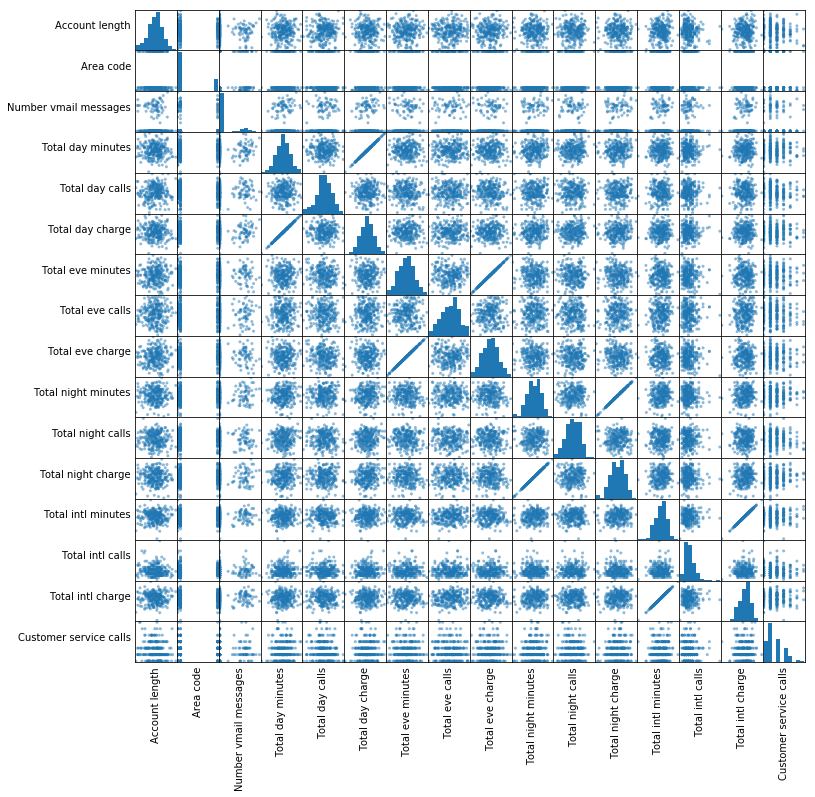

In [14]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf 

def mod_bool(r):
    if r == False :
        return 0.0
    else:
        return 1.0
toNum = udf(mod_bool, DoubleType())

#CV_data = CV_data.withColumn('Churn', toNum(CV_data['Churn']))
CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(CV_data['Churn'])) \
    .withColumn('International plan', toNum(CV_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan'])).cache()

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(final_test_data['Churn'])) \
    .withColumn('International plan', toNum(final_test_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan'])).cache()


In [16]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()


,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,1.0,1.0,1.0,1.0,1.0
Voice mail plan,1.0,1.0,1.0,1.0,1.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


In [17]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

def vectorizeData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

vectorized_CV_data = vectorizeData(stratified_CV_data)


In [18]:
vectorized_CV_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[121.0,1.0,1.0,24...|
|  0.0|[73.0,1.0,1.0,0.0...|
+-----+--------------------+
only showing top 2 rows



In [22]:
#not needed since everything numeric

# Index labels, adding metadata to the label column
#labelIndexer = StringIndexer(inputCol='label',
#                             outputCol='indexedLabel').fit(vectorized_CV_data)

# Automatically identify categorical features and index them
#featureIndexer = VectorIndexer(inputCol='features',
#                               outputCol='indexedFeatures',
#                               maxCategories=2).fit(vectorized_CV_data)

hold_lift=[]


# Train a DecisionTree model
rfTree = RandomForestClassifier(labelCol='label', featuresCol='features')

# Tree in a Pipeline
pipeline = Pipeline(stages=[rfTree])

#Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(rfTree.maxDepth, [2,3,4,5,6,7]).addGrid(rfTree.subsamplingRate,[0.5,0.75]).build()

# Set auc score as evaluation metric for best model selection
evaluator =BinaryClassificationEvaluator(labelCol='label',
                                              rawPredictionCol='prediction')    
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

##################Loop Here##############################################################################


for i in range(0,50):
    
    #split train into train and test
    train,test = vectorized_CV_data.randomSplit([0.7,0.3])

    CV_model = crossval.fit(train)

    # Fetch best model
    bst_model = CV_model.bestModel.stages[0] #i believe stages is from the pipeline index

    pred=bst_model.transform(test)
    pred=pred.select('probability').toPandas()
    pred1=pred['probability'].apply(lambda x: x[1]).values
    true_test_y = test.select('label').toPandas().values


    #calc lift
    d=np.column_stack([true_test_y,pred1])
    hold_lift.append(lift_deciles(d))
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [23]:
hold_lift[0]

array([2.15789474, 2.05263158, 1.84465195, 1.71052632, 1.56553148,
       1.35087719, 1.29775488, 1.15789474, 1.07894737, 1.        ])

In [24]:
bst_model.save('/home/jma/Documents/code/mod1.model') #save


Py4JJavaError: An error occurred while calling o227568.save.
: java.io.IOException: Path /home/jma/Documents/code/mod1.model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:109)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [25]:
model2 = RandomForestClassificationModel.load('/home/jma/Documents/code/mod1.model') #load



In [26]:
model2.transform(test).show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[4.0,1.0,1.0,0.0,...|[15.0077611209600...|[0.75038805604800...|       0.0|
|  0.0|[11.0,1.0,1.0,38....|[14.8028813347300...|[0.74014406673650...|       0.0|
|  0.0|[30.0,1.0,1.0,0.0...|[13.0148914801730...|[0.65074457400865...|       0.0|
|  0.0|[35.0,1.0,1.0,0.0...|[14.9118020671842...|[0.74559010335921...|       0.0|
|  0.0|[36.0,1.0,1.0,0.0...|[8.89163632738683...|[0.44458181636934...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



<h3> Another approach to fitting a model - specifically how to use a pipeline to get data in the correct format without using map which failed so far on 5/3 setup (believe numpy needed on all nodes and it was not </h3>

In [27]:


from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer,VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

transformer=VectorAssembler(inputCols=[x for x in stratified_CV_data.columns if x != 'Churn'],
                              outputCol="features")

indexer = StringIndexer(inputCol="Churn", outputCol="label")


# Train a DecisionTree model
rfTree = RandomForestClassifier(labelCol='label', featuresCol='features')

# Tree in a Pipeline
pipeline = Pipeline(stages=[transformer, indexer, rfTree])

#Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(rfTree.maxDepth, [2,3,4,5,6,7]).addGrid(rfTree.subsamplingRate,[0.5,0.75]).build()

# Set auc score as evaluation metric for best model selection
evaluator =BinaryClassificationEvaluator(labelCol='label',
                                              rawPredictionCol='prediction')    
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)


#split train into train and test
train,test = stratified_CV_data .randomSplit([0.7,0.3])

CV_model = crossval.fit(train)

# Fetch best model
bst_model = CV_model.bestModel.stages[2] #i believe stages is from the pipeline index



In [28]:
bst_model

RandomForestClassificationModel (uid=RandomForestClassifier_4c2085c6770aa7dc7f73) with 20 trees